<a href="https://colab.research.google.com/github/bghaendler/BJBS-AI-LAB/blob/master/BJBS_AI_Lab_Session_02_CoronaVirus_Conv2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img width="300" src="https://raw.githubusercontent.com/bghaendler/BJBS-AI-LAB/master/img/BJBSAILogo.png" align="right"> 
# Session 2: CoronaVirus -Conv2019 Analysis

## Libraries

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
#!pip install geopy

In [0]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve
from geopy.geocoders import Nominatim

In [0]:
import operator

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [0]:
import plotly
import plotly.express as px

In [0]:
#import os
#print(os.listdir("input"))

## Exploratory Data Analysis

### Data download

Data source: https://github.com/CSSEGISandData/COVID-19

In [0]:
githubLoc = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'

In [0]:
from datetime import date, timedelta

sdate = date(2020, 1, 22)   # start date
edate = date.today()   # end date

delta = edate - sdate       # as timedelta

appended_data = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    #print(day.strftime('%m-%d-%Y'))
    try:
      df = pd.read_csv(githubLoc + day.strftime('%m-%d-%Y')+".csv", parse_dates=True)
      appended_data.append(df)
    except:
      pass
df_corona = pd.concat(appended_data)
df_corona["Last Update"] = df_corona["Last Update"].astype('datetime64[D]')


In [188]:
df_corona.tail(10)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
95,"Humboldt County, CA",US,2020-02-21,1.0,0.0,0.0
96,"Los Angeles, CA",US,2020-02-01,1.0,0.0,0.0
97,"Madison, WI",US,2020-02-05,1.0,0.0,0.0
98,"Orange, CA",US,2020-02-01,1.0,0.0,0.0
99,"San Antonio, TX",US,2020-02-13,1.0,0.0,0.0
100,"Seattle, WA",US,2020-02-09,1.0,0.0,1.0
101,"Tempe, AZ",US,2020-02-25,1.0,0.0,1.0
102,"Lackland, TX (From Diamond Princess)",US,2020-02-24,0.0,0.0,0.0
103,"Omaha, NE (From Diamond Princess)",US,2020-02-24,0.0,0.0,0.0
104,"Travis, CA (From Diamond Princess)",US,2020-02-24,0.0,0.0,0.0


In [0]:
df_corona["Last Update"] = df_corona["Last Update"].astype('datetime64[D]')
df_corona["Date"] = df_corona["Last Update"].astype('datetime64[D]')
df_corona['Country/Region'].replace({'Mainland China':'China'},inplace=True)
df_corona.fillna(value=0, inplace=True)


### Show Cases by Date

In [190]:
df_byDate = df_corona.groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date")
df_byDate["mort_Rate"] =(df_byDate["Deaths"]/df_byDate["Confirmed"])*100
df_byDate.tail(10)

,Confirmed,Deaths,Recovered,mort_Rate
Date,,,,
2020-02-18,75029.0,2004.0,14315.0,2.670967
2020-02-19,75634.0,2120.0,16136.0,2.802972
2020-02-20,77227.0,2249.0,18060.0,2.912194
2020-02-21,76713.0,2250.0,19218.0,2.933010
2020-02-22,77612.0,2451.0,22613.0,3.158017
2020-02-23,80435.0,2475.0,23452.0,3.077019
2020-02-24,78705.0,2626.0,25128.0,3.336510
2020-02-25,79629.0,2702.0,27861.0,3.393236
2020-02-26,82142.0,2774.0,30359.0,3.377079


### Number of Cases in China

In [191]:
nb_cases_day = df_corona.groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date").diff().fillna(value=0)
nb_cases_day_China = df_corona.loc[df_corona["Country/Region"] == "China"].groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date").diff().fillna(value=0)
nb_cases_day_China.tail()

,Confirmed,Deaths,Recovered
Date,,,
2020-02-23,324.0,6.0,709.0
2020-02-24,89.0,150.0,1726.0
2020-02-25,466.0,66.0,2646.0
2020-02-26,371.0,54.0,2386.0
2020-02-27,397.0,27.0,2787.0


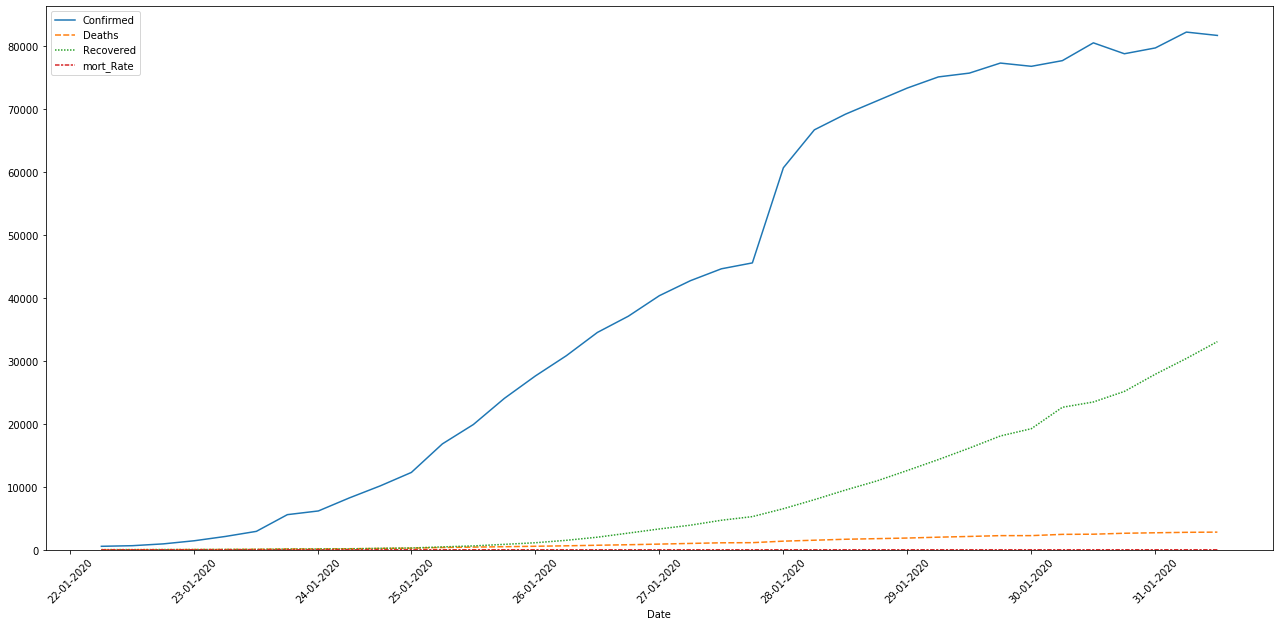

In [192]:
fig, ax = plt.subplots(figsize = (22,10))  
fig = sns.lineplot( 
    data=df_byDate)  
fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

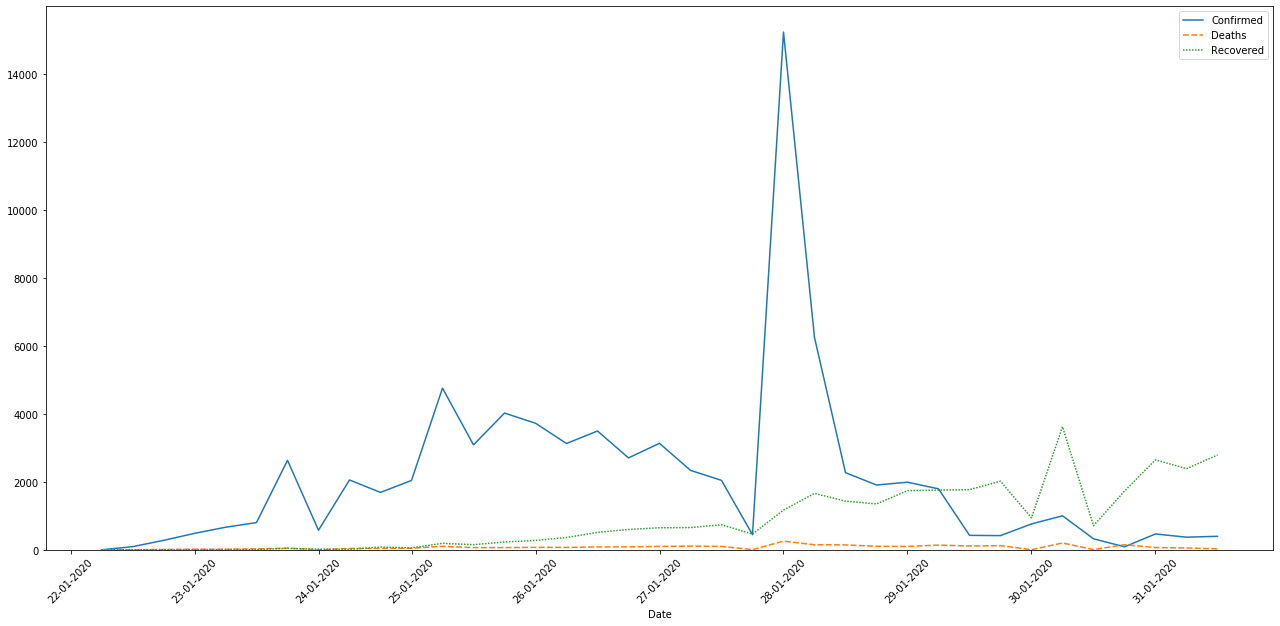

In [193]:
fig, ax = plt.subplots(figsize = (22,10))  
fig = sns.lineplot( 
    data=nb_cases_day_China)  
fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

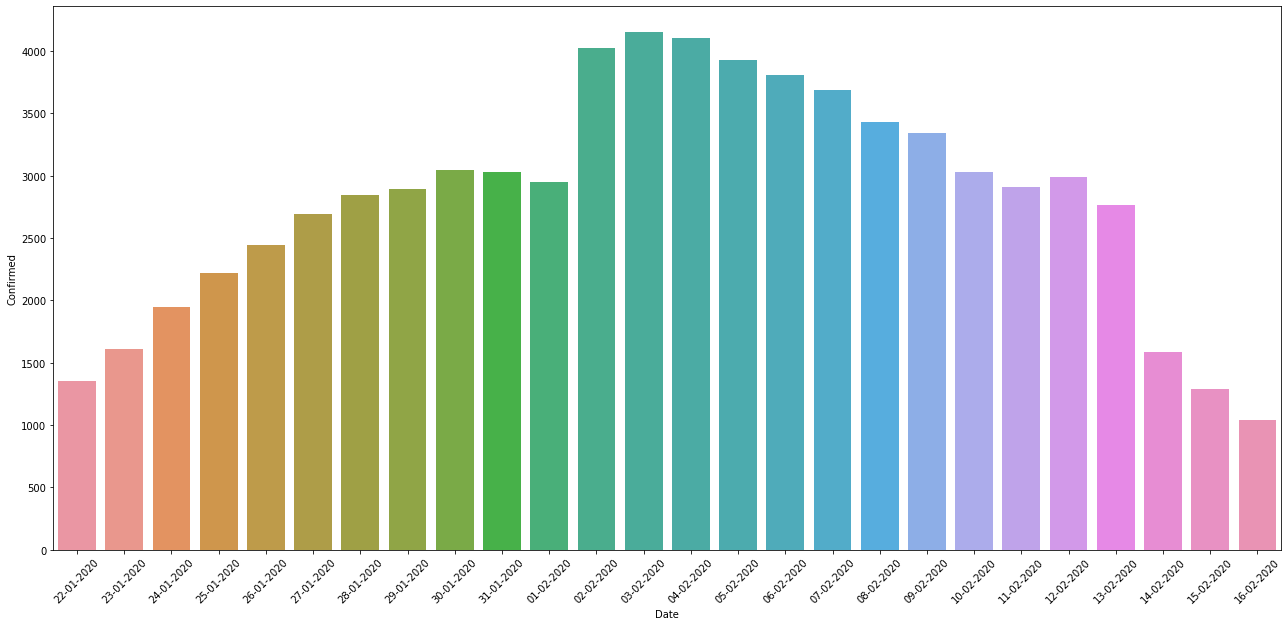

In [194]:
fig, ax = plt.subplots(figsize = (22,10))    
fig = sns.barplot(
    x = "Date", 
    y = "Confirmed", 
    data = nb_cases_day.rolling(window=12).mean().dropna().reset_index())

fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

In [195]:
df_corona["Date"].max()

Timestamp('2020-02-27 00:00:00')

In [196]:
df_corona.describe()

,Confirmed,Deaths,Recovered
count,2585.000000,2585.000000,2585.000000
mean,595.882785,16.237524,118.044487
std,4913.280499,167.935348,1036.080708
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,12.000000,0.000000,1.000000
75%,124.000000,1.000000,17.000000
max,65596.000000,2641.000000,23383.000000


### Dataframe Info

In [197]:
df_corona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2585 entries, 0 to 104
Data columns (total 7 columns):
Province/State    2585 non-null object
Country/Region    2585 non-null object
Last Update       2585 non-null datetime64[ns]
Confirmed         2585 non-null float64
Deaths            2585 non-null float64
Recovered         2585 non-null float64
Date              2585 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 161.6+ KB


In [198]:
#**Present Gobal condition: confirmed, death and recovered**
print('Data from Day: ' + str(df_corona["Date"].max().strftime('%A %m/%d/%Y')))
print('Globally Confirmed Cases: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Confirmed'].sum())
print('Global Deaths: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Deaths'].sum())
print('Globally Recovered Cases: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Recovered'].sum())

Data from Day: Thursday 02/27/2020
Globally Confirmed Cases:  81611.0
Global Deaths:  2806.0
Globally Recovered Cases:  33029.0


In [199]:
df_corona[['Date','Country/Region','Province/State','Confirmed','Deaths','Recovered']].drop_duplicates(subset=["Date","Province/State"]).groupby(['Date','Country/Region']).sum()

Confirmed  Deaths  Recovered
Date       Country/Region                              
2020-01-22 China               547.0    17.0       28.0
           Hong Kong             0.0     0.0        0.0
           Japan                 2.0     0.0        0.0
           Macau                 1.0     0.0        0.0
           Taiwan                1.0     0.0        0.0
...                              ...     ...        ...
2020-02-27 China             78388.0  2742.0    32798.0
           Hong Kong            92.0     2.0       24.0
           Macau                10.0     0.0        8.0
           South Korea        1766.0    13.0       22.0
           US                    2.0     0.0        0.0

[227 rows x 3 columns]

In [200]:
df_corona.loc[df_corona["Date"]==df_corona["Date"].max()].groupby('Country/Region')['Confirmed','Deaths','Recovered'].sum().sort_values(by="Confirmed", ascending=False)

,Confirmed,Deaths,Recovered
Country/Region,,,
China,78388.0,2742.0,32798.0
South Korea,1766.0,13.0,22.0
Italy,655.0,17.0,45.0
Iran,245.0,26.0,49.0
Japan,214.0,4.0,22.0
Hong Kong,92.0,2.0,24.0
Germany,46.0,0.0,16.0
Kuwait,43.0,0.0,0.0
France,38.0,2.0,11.0


In [201]:
df_corona.loc[df_corona["Country/Region"] == "China"].groupby("Date").sum()

,Confirmed,Deaths,Recovered
Date,,,
2020-01-22,547.0,17.0,28.0
2020-01-23,639.0,18.0,30.0
2020-01-24,916.0,26.0,36.0
2020-01-25,1399.0,42.0,39.0
2020-01-26,2062.0,56.0,49.0
2020-01-27,2863.0,82.0,58.0
2020-01-28,5494.0,131.0,101.0
2020-01-29,6070.0,133.0,120.0
2020-01-30,8124.0,171.0,135.0


In [202]:
CasesByCountry = df_corona.groupby(by=['Country/Region','Date'])['Confirmed','Deaths','Recovered'].sum().reset_index()
CasesByCountry.loc[CasesByCountry["Date"] == CasesByCountry["Date"].max()]
CasesByCountry.loc[CasesByCountry["Date"] == '2020-02-23']

,Country/Region,Date,Confirmed,Deaths,Recovered
85,China,2020-02-23,77065.0,2445.0,23253.0
167,Hong Kong,2020-02-23,74.0,2.0,11.0
182,Iran,2020-02-23,43.0,8.0,0.0
187,Iraq,2020-02-23,0.0,0.0,0.0
199,Italy,2020-02-23,155.0,3.0,2.0
233,Japan,2020-02-23,147.0,1.0,22.0
312,Others,2020-02-23,2073.0,9.0,0.0
354,Singapore,2020-02-23,178.0,0.0,102.0
384,South Korea,2020-02-23,602.0,6.0,18.0
428,Taiwan,2020-02-23,28.0,1.0,2.0


In [203]:
pivotTableCorna = pd.pivot_table(df_corona,index="Country/Region", columns="Date", values="Confirmed" ,fill_value=0,aggfunc='sum').reset_index()
pivotTableCorna

Date,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0
1,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0
2,Australia,0,0,0,4,4,5,5,5,9,9,72,34,0,6,0,32,10,0,60,0,0,0,120,0,0,0,22,0,0,0,39,35,0,0,0,0,8
3,Austria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3
4,Bahrain,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,23,66,0
5,Belgium,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0
6,Brazil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
7,Cambodia,0,0,0,0,0,1,1,1,1,12,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Canada,0,0,0,0,1,1,2,2,3,3,13,0,0,42,4,0,40,0,0,0,0,16,0,0,0,0,20,0,0,0,30,0,0,9,14,0,12
9,China,547,639,916,1399,2062,2863,5494,6070,8124,9812,11852,16606,19692,23713,27436,30562,34056,36759,39890,42226,44268,44714,59939,66183,68452,70357,72345,74138,74563,74980,75741,76741,77065,77154,77620,77991,78388


In [0]:
#f, ax = plt.subplots(figsize=(17, 15))
#ax = sns.heatmap(pivotTableCorna)

In [205]:
CasesByCountry.tail()

,Country/Region,Date,Confirmed,Deaths,Recovered
505,Vietnam,2020-02-10,14.0,0.0,1.0
506,Vietnam,2020-02-11,30.0,0.0,12.0
507,Vietnam,2020-02-13,128.0,0.0,56.0
508,Vietnam,2020-02-21,64.0,0.0,56.0
509,Vietnam,2020-02-25,48.0,0.0,48.0


In [206]:
CasesByCountry["Date"].max()

Timestamp('2020-02-27 00:00:00')

In [207]:
df_corona.loc[
              df_corona["Date"]==df_corona["Date"].max()].groupby(
                  ['Province/State'])['Confirmed','Deaths','Recovered'].sum().sort_values(
                      by="Confirmed", ascending=False).head(10)

,Confirmed,Deaths,Recovered
Province/State,,,
Hubei,65596.0,2641.0,23383.0
0,3099.0,62.0,194.0
Guangdong,1347.0,7.0,890.0
Henan,1272.0,20.0,1068.0
Zhejiang,1205.0,1.0,932.0
Hunan,1017.0,4.0,804.0
Anhui,989.0,6.0,792.0
Jiangxi,934.0,1.0,754.0
Shandong,756.0,6.0,387.0


In [0]:
df_corona2 = df_corona.groupby(['Date','Country/Region'])['Confirmed','Deaths','Recovered'].sum().sort_values(by="Confirmed", ascending=False)

In [0]:
df_corona2.reset_index(inplace=True)

In [210]:
fig = px.bar(
    df_corona2[['Date','Confirmed','Deaths', 'Recovered','Country/Region']], 
    x='Date', 
    y='Confirmed', 
    hover_data=['Country/Region', 'Deaths', 'Recovered'], 
    color='Country/Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for each country',
                              font=dict(family='Arial',
                                        size=10,
                                        color='rgb(56,37,47)'),
                              showarrow=False)
                              )
fig.update_layout(annotations=annotations)
fig.show()

In [0]:
df_corona3 =df_corona2.loc[df_corona2["Country/Region"] !="China"]

In [212]:
fig = px.bar(
    df_corona3[['Date','Confirmed','Deaths', 'Recovered','Country/Region']], 
    x='Date', 
    y='Confirmed', 
    hover_data=['Country/Region', 'Deaths', 'Recovered'], 
    color='Country/Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for each country',
                              font=dict(family='Arial',
                                        size=10,
                                        color='rgb(56,37,47)'),
                              showarrow=False)
                              )
fig.update_layout(annotations=annotations)
fig.show()

In [213]:
fig = px.bar(df_corona.loc[df_corona['Country/Region'] == 'China'], x='Date', y='Confirmed', hover_data=['Province/State', 'Deaths', 'Recovered'], color='Province/State')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for Mainland China',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [214]:
fig = px.bar(df_corona.loc[df_corona['Country/Region'] == 'Singapore'].drop_duplicates(subset="Date"), 
             x='Date', y='Confirmed', 
             hover_data=['Deaths', 'Recovered'])
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for Singapore',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [215]:
fig = px.bar(df_corona, x='Date', y='Deaths', hover_data=['Province/State', 'Confirmed', 'Recovered'], color='Country/Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Death bar plot for each country',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [216]:
fig = px.bar(df_corona.loc[df_corona['Country/Region'] == 'China'], x='Date', y='Deaths', hover_data=['Province/State', 'Confirmed', 'Recovered'], color='Province/State')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Death bar plot for Mainland China',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

## Predicting Using Facebook Prophet vs Sklearn

In [0]:
from fbprophet.plot import plot_plotly
from fbprophet import Prophet

In [0]:
confirmed_training_dataset = pd.DataFrame(df_corona.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#confirmed_training_dataset

In [219]:
# Making the Model
prophet = Prophet()
prophet.fit(confirmed_training_dataset)
future = prophet.make_future_dataframe(periods=37)
confirmed_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [220]:
fig = plot_plotly(prophet, confirmed_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

In [0]:
death_training_dataset = pd.DataFrame(df_corona.groupby('Date')['Deaths'].sum().reset_index()).rename(columns={'Date': 'ds', 'Deaths': 'y'})
#death_training_dataset

In [222]:
# Making the Model
prophet = Prophet()
prophet.fit(death_training_dataset)
future = prophet.make_future_dataframe(periods=30)
deaths_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [223]:
fig = plot_plotly(prophet, deaths_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions of Deaths',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

In [0]:
sg_confirmed_training_dataset = pd.DataFrame(df_corona.loc[df_corona['Country/Region'] == 'Singapore'].drop_duplicates(subset="Date").groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#sg_confirmed_training_dataset

In [225]:
# Making the Model
prophet = Prophet()
prophet.fit(sg_confirmed_training_dataset)
future = prophet.make_future_dataframe(periods=30)
sg_confirmed_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


In [226]:
fig = plot_plotly(prophet, sg_confirmed_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

### Number of cases per day

In [0]:
df_corona_cases_day_sg =df_corona.loc[df_corona["Country/Region"] == "Singapore"].drop_duplicates(subset="Date").groupby(by=["Country/Region","Date"]).sum().diff()
#df_corona.loc[df_corona["Country/Region"] == "Singapore"].groupby(by=["Country/Region","Date"]).sum()

### Prediction Singapore Cases Per Day

In [0]:
SG_CasesPerDay_training_dataset = pd.DataFrame(df_corona_cases_day_sg.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#SG_CasesPerDay_training_dataset

In [229]:
# Making the Model
prophet = Prophet()
prophet.fit(SG_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=30)
SG_CasesPerDay_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


In [230]:
fig = plot_plotly(prophet, SG_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Singapore Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

1.64923833955081
0.43281084555609795


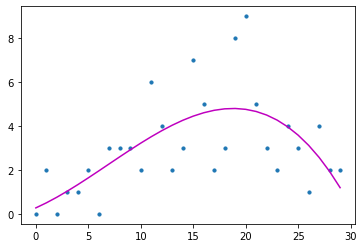

In [231]:
x = np.arange(0, SG_CasesPerDay_training_dataset.shape[0], dtype=int)
y = SG_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### China Prediction Cases Per Day

In [0]:
df_corona_cases_day_cn = df_corona.loc[df_corona["Country/Region"] == "China"].drop_duplicates(subset="Date").groupby(by=["Country/Region","Date"]).sum().diff()

In [0]:
CN_CasesPerDay_training_dataset = pd.DataFrame(df_corona_cases_day_cn.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#CN_CasesPerDay_training_dataset

In [234]:
# Making the Model
prophet = Prophet()
prophet.fit(CN_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=30)
CN_CasesPerDay_forecast = prophet.predict(future)
#CN_CasesPerDay_forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [235]:
fig = plot_plotly(prophet, CN_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='China Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

2248.2252234482266
0.22366833300102296


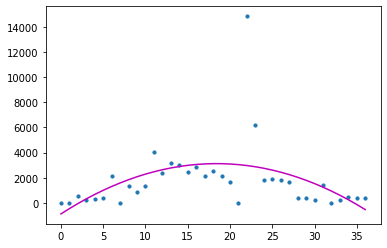

In [236]:
x = np.arange(0, CN_CasesPerDay_training_dataset.shape[0], dtype=int)
y = CN_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### Calculate Mortality Rate
By Country/Date

In [237]:
df_corona.groupby("Date").sum()

,Confirmed,Deaths,Recovered
Date,,,
2020-01-22,555.0,17.0,28.0
2020-01-23,653.0,18.0,30.0
2020-01-24,941.0,26.0,36.0
2020-01-25,1438.0,42.0,39.0
2020-01-26,2118.0,56.0,52.0
2020-01-27,2927.0,82.0,61.0
2020-01-28,5578.0,131.0,107.0
2020-01-29,6165.0,133.0,126.0
2020-01-30,8235.0,171.0,143.0


In [238]:
df_corona_MortRate = df_corona.groupby(by=["Date"]).sum().reset_index()
df_corona_MortRate

,Date,Confirmed,Deaths,Recovered
0,2020-01-22,555.0,17.0,28.0
1,2020-01-23,653.0,18.0,30.0
2,2020-01-24,941.0,26.0,36.0
3,2020-01-25,1438.0,42.0,39.0
4,2020-01-26,2118.0,56.0,52.0
5,2020-01-27,2927.0,82.0,61.0
6,2020-01-28,5578.0,131.0,107.0
7,2020-01-29,6165.0,133.0,126.0
8,2020-01-30,8235.0,171.0,143.0
9,2020-01-31,10151.0,213.0,239.0


In [0]:
df_corona_MortRate["MortalityRate"] = df_corona_MortRate["Deaths"]/df_corona_MortRate["Confirmed"]
df_corona_MortRate["MortalityRate"].replace([np.inf, -np.inf], np.nan)
df_corona_MortRate["MortalityRate"].fillna(value=0, inplace=True)


In [0]:
#df_corona_MortRate["MortalityRate"].loc[(~np.isfinite(df_corona_MortRate["MortalityRate"])) & df_corona_MortRate["MortalityRate"].notnull()] = 0

In [241]:
df_corona_MortRate.sort_values(by="Date", ascending=False)

,Date,Confirmed,Deaths,Recovered,MortalityRate
36,2020-02-27,81611.0,2806.0,33029.0,0.034383
35,2020-02-26,82142.0,2774.0,30359.0,0.033771
34,2020-02-25,79629.0,2702.0,27861.0,0.033932
33,2020-02-24,78705.0,2626.0,25128.0,0.033365
32,2020-02-23,80435.0,2475.0,23452.0,0.030770
31,2020-02-22,77612.0,2451.0,22613.0,0.031580
30,2020-02-21,76713.0,2250.0,19218.0,0.029330
29,2020-02-20,77227.0,2249.0,18060.0,0.029122
28,2020-02-19,75634.0,2120.0,16136.0,0.028030
27,2020-02-18,75029.0,2004.0,14315.0,0.026710


### Geolocation 1

In [242]:
import os
os.environ['KAGGLE_USERNAME'] = "bghai19" # username from the json file
os.environ['KAGGLE_KEY'] = "4947c3935b9ad98eacd876741ff7c11c" # key from the json file
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 # api copied from kaggle

skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [243]:
!kaggle datasets download -d parulpandey/world-coordinates

world-coordinates.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import zipfile

In [0]:
with zipfile.ZipFile("/content/world-coordinates.zip","r") as zip_ref:
    zip_ref.extractall("input")

In [246]:
# Importing the world_coordinates dataset
world_coordinates = pd.read_csv('/content/input/world_coordinates.csv')
world_coordinates.tail()


,Code,Country,latitude,longitude
239,YE,Yemen,15.552727,48.516388
240,YT,Mayotte,-12.827500,45.166244
241,ZA,South Africa,-30.559482,22.937506
242,ZM,Zambia,-13.133897,27.849332
243,ZW,Zimbabwe,-19.015438,29.154857


In [247]:
# Merging the coordinates dataframe with original dataframe
df_corona_world = pd.merge(world_coordinates,df_corona,left_on='Country',right_on='Country/Region')
df_corona_world = df_corona_world.loc[df_corona_world["Date"] == df_corona_world["Date"].max()]
df_corona_world= df_corona_world.groupby(by=["Date","Country/Region","latitude","longitude"]).sum().reset_index()
df_corona_world

,Date,Country/Region,latitude,longitude,Confirmed,Deaths,Recovered
0,2020-02-27,Australia,-25.274398,133.775136,8.0,0.0,0.0
1,2020-02-27,Austria,47.516231,14.550072,3.0,0.0,0.0
2,2020-02-27,Canada,56.130366,-106.346771,12.0,0.0,5.0
3,2020-02-27,China,35.861660,104.195397,78388.0,2742.0,32798.0
4,2020-02-27,Denmark,56.263920,9.501785,1.0,0.0,0.0
5,2020-02-27,Estonia,58.595272,25.013607,1.0,0.0,0.0
6,2020-02-27,France,46.227638,2.213749,38.0,2.0,11.0
7,2020-02-27,Georgia,42.315407,43.356892,1.0,0.0,0.0
8,2020-02-27,Germany,51.165691,10.451526,46.0,0.0,16.0
9,2020-02-27,Greece,39.074208,21.824312,3.0,0.0,0.0


In [0]:
#df_corona_world.info()

In [0]:
import plotly.express as px
import plotly.graph_objects as go

In [250]:
fig = go.Figure(data=go.Scattergeo(
        #locationmode = 'iso_alpha',
        lon = df_corona_world['longitude'],
        lat = df_corona_world['latitude'],
        text = df_corona_world['Country/Region'] + " " + df_corona_world['Confirmed'].astype(str) + ' Confirmed Cases',
        mode = 'markers',
        marker = dict(
            size = 12,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = 0,
            color = df_corona_world['Confirmed'],
            cmax = df_corona_world['Confirmed'].max(),
            colorbar_title="Cases by" + str(df_corona_world['Date'].max())
        )))

fig.update_layout(
        title = 'Corona Virus by Country)',
        geo = dict(
            scope='world',
            #projection_type='natural earth',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

In [251]:

scl = [0,"#000000"],[0.5,"rgb(255, 0, 0)"],[1,"rgb(150, 204, 0)"]

fig = go.Figure(data=go.Scattergeo(
    lon = df_corona_world['longitude'],
    lat = df_corona_world['latitude'], 
    text = df_corona_world['Country/Region'] + " " +df_corona_world['Confirmed'].astype(str),
    marker = dict(
        color = df_corona_world['Confirmed'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.7,
        size = (df_corona_world['Confirmed']/2000)+10
    )
))

fig.update_layout(
    geo = dict(
        scope = 'world',
        showland = True,
        landcolor = "rgb(242, 242, 242)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,


    ),
    title='CoronaViruse cases ' + df_corona_world['Date'].max().strftime('%A %m/%d/%Y'),
)
fig.show()

### Geolocation2

In [0]:
import folium 
from folium import plugins

In [253]:
# create map and display it
world_map = folium.Map(location=[10, -20], zoom_start=2.3)

for lat, lon, value, name, deaths in zip(df_corona_world['latitude'], df_corona_world['longitude'], df_corona_world['Confirmed'], df_corona_world['Country/Region'], df_corona_world['Deaths']):
    folium.CircleMarker([lat, lon],
                        radius=1+(deaths/100),
                        popup = ('<strong>Country</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Confirmed Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(world_map)
world_map